In [4]:
import numpy as np
import pandas as pd
import heapq
import random

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

from tools import *

In [5]:
# Functions we wrote
def get_npreds(songs, model, df, n_preds=10, n_neigh=10):
    """
    given a list of songs as titles, a NearestNeighbor model, sparse dataframe, and number of desired predictions,
    outputs an array with 1's at indices of predicted songs
    
    INPUT:
    songs: list or array of song titles from those found in 100_Sample_MilPlay_Spotify
    model: NearestNeighbor model
    df: sparse dataframe (playlist x song title) 
    n_preds: int, number of predictions to be made
    
    RETURNS:
    predictions: list of 1's at indexes corresponding to newly predicted songs
    """
    seed_play = get_song_bool_list(songs, df)
    
    neigh_play = model.kneighbors(X=[seed_play], return_distance=False, n_neighbors=n_neigh)
    pids = neigh_play[0] #All the playlists; indexes don't correspond to pid
    sims = defaultdict(int)

    tracks = [list(df.columns[train_df.iloc[pid] == 1]) for pid in pids]
    
    for i, playlist in enumerate(tracks): 
        for song in playlist:
            if song not in songs:
                sims[song] += (1/(i+1))
                
    closest_songs = heapq.nlargest(n_preds, sims, key=sims.get)
    return np.array(get_song_bool_list(closest_songs, df))

In [6]:
# Use the 100 playlist sampled from the million playlist data.

sample_df = pd.read_csv("data/100_Sample_MilPlay_Spotify.csv", index_col="pos")
cleaned_df = sample_df.drop(columns=["track_uri", "artist_uri", "album_uri", "album_name", "type", "uri", "track_href", "analysis_url", "duration_ms.1"])

In [7]:
#song_pl_df = pd.DataFrame()

#for song in set(cleaned_df["track_name"]):
#    in_playlist = [1 if song in list(cleaned_df.loc[cleaned_df["pid"] == pid, "track_name"]) else 0 for pid in set(cleaned_df["pid"])]
#    song_pl_df[song] = in_playlist
    
#song_pl_df.to_csv("data/sparse_df.csv") #save for later

In [8]:
song_pl_df = pd.read_csv("data/sparse_df.csv")

In [9]:
train_df, test_df = train_test_split(song_pl_df, test_size=0.3, random_state=109)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
#Train KNeighbors model with 30 neighbors
KN_model = NearestNeighbors(n_neighbors=30, metric="cosine")
KN_model.fit(train_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                 radius=1.0)

In [11]:
# Scores for train
# Obscure each playlist in set by removing half the songs
obscured_plays = train_df.copy(deep=True)

for index, playlist in train_df.iterrows():
    obscured_list = remove_songs(list(playlist), 0.5)
    obscured_plays.iloc[index] = obscured_list
    
# Predict the number of songs we removed in the obscuring
train_preds = []
for index, playlist in obscured_plays.iterrows():
    train_preds.append(get_npreds(get_titles(playlist, song_pl_df), KN_model, train_df, int(sum(playlist))))
    
# Score the model's performance in the training set. 
train_scores = []
train_ndcgs = []

for i, pred in enumerate(train_preds):
    pred_idx = [idx for idx, p in enumerate(pred) if p == 1]
    right = np.array(train_df.iloc[i]) - np.array(obscured_plays.iloc[i])
    right_idx = [idx for idx, r in enumerate(right) if r == 1]
    train_scores.append(sum([1 for pidx in pred_idx if pidx in right_idx])/len(pred_idx))
    r_train = [1 if idx in pred_idx else 0 for idx in right_idx]
    train_ndcgs.append(ndcg_at_k(r_train, len(r_train)))

print("Mean R-precision score for train set: {}".format(np.mean(train_scores)))
print("Mean NDCG score for train set: {}".format(np.mean(train_ndcgs)))

Mean R-precision score for train set: 0.9678228818434701
Mean NDCG score for train set: 0.9967179218563759


In [12]:
# Scores for test

# Obscure each playlist in set by removing half the songs
obscured_test = test_df.copy()

for index, playlist in test_df.iterrows():
    obscured_list = remove_songs(list(playlist), 0.5)
    obscured_test.iloc[index] = obscured_list

# Predict the number of songs we removed in the obscuring
test_preds = []
for index, playlist in obscured_test.iterrows():
    test_preds.append(get_npreds(get_titles(playlist, song_pl_df), KN_model, test_df, int(sum(playlist))))
    
# Score the model's performance in the test set. 
test_scores = []
test_ndcgs = []
for i, pred in enumerate(test_preds):
    pred_idx = [idx for idx, p in enumerate(pred) if p == 1]
    right = np.array(test_df.iloc[i]) - np.array(obscured_plays.iloc[i])
    right_idx = [idx for idx, r in enumerate(right) if r == 1]
    test_scores.append(sum([1 for pidx in pred_idx if pidx in right_idx])/len(pred_idx))
    r_test = [1 if idx in pred_idx else 0 for idx in right_idx]
    test_ndcgs.append(ndcg_at_k(r_test, len(r_test)))

In [21]:
# Vary number of neighbors
mean_rprec = []
mean_ndcgs = []

for n_neigh in range(1, 80, 2):
    KN_model = NearestNeighbors(n_neighbors=n_neigh, metric="cosine")
    KN_model.fit(train_df)
    test_preds = []
    for index, playlist in obscured_test.iterrows():
        test_preds.append(get_npreds(get_titles(playlist, song_pl_df), KN_model, test_df, int(sum(playlist)), n_neigh=n_neigh))

    # Score the model's performance in the test set. 
    test_scores = []
    test_ndcgs = []
    for i, pred in enumerate(test_preds):
        pred_idx = [idx for idx, p in enumerate(pred) if p == 1]
        right = np.array(test_df.iloc[i]) - np.array(obscured_plays.iloc[i])
        right_idx = [idx for idx, r in enumerate(right) if r == 1]
        test_scores.append(sum([1 for pidx in pred_idx if pidx in right_idx])/len(pred_idx))
        r_test = [1 if idx in pred_idx else 0 for idx in right_idx]
        test_ndcgs.append(ndcg_at_k(r_test, len(r_test)))
    mean_rprec.append(np.mean(test_scores))
    mean_ndcgs.append(np.mean(test_ndcgs))

In [22]:
best_neigh_idx = np.argmax(np.array(mean_rprec) + np.array(mean_ndcgs))
best_neigh = 2*(best_neigh_idx)+1

print("Value of n_neighbors that maximizes R-precision + NDCG: {}".format(best_neigh))
print("Mean R-precision score for test set for best n_neighbors: {}".format(mean_rprec[best_neigh_idx]))
print("Mean NDCGs score for test set for best n_neighbors: {}".format((mean_ndcgs[best_neigh_idx])))

Value of n_neighbors that maximizes R-precision + NDCG: 23
Mean R-precision score for test set for best n_neighbors: 0.03800877678068774
Mean NDCGs score for test set for best n_neighbors: 0.13925007726863173


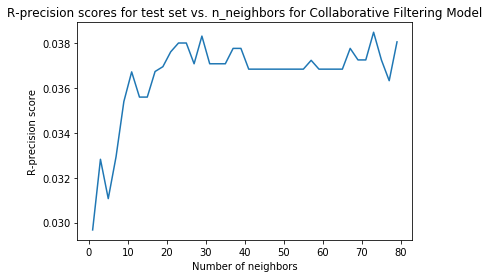

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(np.arange(1, 80, 2), mean_rprec)
plt.title("R-precision scores for test set vs. n_neighbors for Collaborative Filtering Model")
plt.xlabel("Number of neighbors")
plt.ylabel("R-precision score")
plt.savefig("data/CF_R.png")

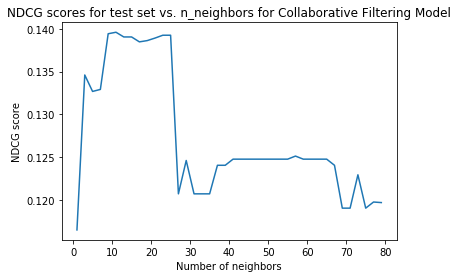

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(np.arange(1, 80, 2), mean_ndcgs)
plt.title("NDCG scores for test set vs. n_neighbors for Collaborative Filtering Model")
plt.xlabel("Number of neighbors")
plt.ylabel("NDCG score")
plt.savefig("data/CF_NDCG.png")